In [1]:
%matplotlib inline


import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.cluster import AgglomerativeClustering


from context import messi
from messi.data_processing import *
from messi.hme import hme

# Example usage of MESSI  

MESSI can be directly executed by the command-line tool we provide, where by default we assume a one layer logistic gate with MROTS experts. Other than this particular configuration, we also support various other ones (different models for experts/gates, multiple layers of gates etc.) through the messi.hme module. Here, we take the excitatory neurons in female parenting animals of the MERFISH hypothalamus dataset as an example, to illustrate how to:  

1. Train and test a MESSI model 
2. Analyze the model parameters to infer cell subtypes differ in signaling genes 
3. Train and test with other configurations

The command-line tool covers usage 1. 

## User-definied arguements

Same as the arguements for the command-line usage. See details information of each arguements in the docs. 

In [100]:
input_path = '../../input/merfish/'
output_path = '../output/'
data_type = 'merfish'
sex = 'Female'
behavior = 'Parenting'
behavior_no_space = behavior.replace(" ", "_")
current_cell_type = 'Excitatory'
current_cell_type_no_space = current_cell_type.replace(" ", "_")

n_classes_0 = 1
n_classes_1 = 5
n_epochs = 5  # for example usage only; we recommend using the default 20 n_epochs 

preprocess = 'neighbor_cat'
top_k_response = None  
top_k_regulator = None
response_list_prior = None
regulator_list_prior = None
response_type = 'original'  # use raw values to fit the model
condition = f"response_{top_k_response}_l1_{n_classes_0}_l2_{n_classes_1}"

## Read in and preprocess data

### Read in the ligad & receptor list and meta information for the dataset

The meta information can be obtained by running readyData.py. See the details in the docs. 

In [101]:
# set data reading functions corresponding to the data type
if data_type == 'merfish':
    read_meta = read_meta_merfish
    read_data = read_merfish_data
    get_idx_per_dataset = get_idx_per_dataset_merfish
else:
    raise NotImplementedError(f"Now only support processing MERFISH hypothalamus data.")

# read in ligand and receptor lists
l_u, r_u = get_lr_pairs(input_path = '../messi/input/')

# read in meta information about the dataset
meta_all, meta_all_columns, cell_types_dict, genes_list, genes_list_u = \
    read_meta(input_path, behavior_no_space, sex)

# get all available animals/samples
all_animals = list(set(meta_all[:, meta_all_columns['Animal_ID']]))

Removed genes: {'Blank_3', 'Blank_2', 'Blank_5', 'Blank_1', 'Blank_4', 'Fos'}
Total number of cell types for merfish: 16


### Read in and preprocess MERFISH data

#### Split the data into train and test sets 

In [102]:
test_animal  = 16
test_animals = [test_animal]
samples_test = np.array(test_animals)
samples_train = np.array(list(set(all_animals)-set(test_animals)))
print(f"Test set is {samples_test}")
print(f"Training set is {samples_train}")

Test set is [16]
Training set is [17 18 19]


In [103]:
bregma = None
idx_train, idx_test, idx_train_in_general, \
idx_test_in_general, idx_train_in_dataset, \
idx_test_in_dataset, meta_per_dataset_train, \
meta_per_dataset_test = find_idx_for_train_test(samples_train, samples_test, 
                                                meta_all, meta_all_columns, data_type, 
                                                current_cell_type, get_idx_per_dataset,
                                                return_in_general = False, 
                                                bregma=bregma)


Preprocess for Excitatory of merfish
8601
2677


#### Read in datasets according to the animal ID
These datasets can be obtained by running readyData.py. See docs for detail.

In [104]:
data_sets = []

for animal_id, bregma in meta_per_dataset_train:
    try:
        hp, hp_cor, hp_genes = read_data(input_path, bregma, animal_id, genes_list)
    except TypeError:
        continue

    hp_columns = dict(zip(hp.columns, range(0, len(hp.columns))))
    hp_cor_columns = dict(zip(hp_cor.columns, range(0, len(hp_cor.columns))))
    hp_genes_columns = dict(zip(hp_genes.columns, range(0, len(hp_genes.columns))))
    data_sets.append([hp.to_numpy(), hp_columns, hp_cor.to_numpy(), hp_cor_columns,
                      hp_genes.to_numpy(), hp_genes_columns])
    del hp, hp_cor, hp_genes

datasets_train = data_sets

data_sets = []

for animal_id, bregma in meta_per_dataset_test:
    try:
        hp, hp_cor, hp_genes = read_data(input_path, bregma, animal_id, genes_list)
    except TypeError:
        continue

    hp_columns = dict(zip(hp.columns, range(0, len(hp.columns))))
    hp_cor_columns = dict(zip(hp_cor.columns, range(0, len(hp_cor.columns))))
    hp_genes_columns = dict(zip(hp_genes.columns, range(0, len(hp_genes.columns))))
    data_sets.append([hp.to_numpy(), hp_columns, hp_cor.to_numpy(), hp_cor_columns,
                      hp_genes.to_numpy(), hp_genes_columns])
    del hp, hp_cor, hp_genes

datasets_test = data_sets

del data_sets

Reading file: merfish_animal17_bregma011.csv
The dimensions of the sample is: (5417, 170)
Reading file: merfish_animal17_bregma016.csv
The dimensions of the sample is: (5361, 170)
Reading file: merfish_animal17_bregma021.csv
The dimensions of the sample is: (5373, 170)
Reading file: merfish_animal17_bregma026.csv
The dimensions of the sample is: (4828, 170)
Reading file: merfish_animal18_bregma011.csv
The dimensions of the sample is: (5665, 170)
Reading file: merfish_animal18_bregma016.csv
The dimensions of the sample is: (5967, 170)
Reading file: merfish_animal18_bregma021.csv
The dimensions of the sample is: (5881, 170)
Reading file: merfish_animal18_bregma026.csv
The dimensions of the sample is: (5555, 170)
Reading file: merfish_animal19_bregma011.csv
The dimensions of the sample is: (5533, 170)
Reading file: merfish_animal19_bregma016.csv
The dimensions of the sample is: (5392, 170)
Reading file: merfish_animal19_bregma021.csv
The dimensions of the sample is: (5194, 170)
Reading fi

## Prepare features & responses

### Prepare different types of features

#### Construct neighborhood graph and get physical neighbors for each cell

In [105]:
if data_type == 'merfish_rna_seq':
    neighbors_train = None
    neighbors_test = None
else: 
    if data_type == 'merfish':
        dis_filter = 100
    else:
        dis_filter = 1e9  
        
    neighbors_train = get_neighbors_datasets(datasets_train, "Del", k=10, dis_filter=dis_filter, include_self = False)
    neighbors_test = get_neighbors_datasets(datasets_test, "Del", k=10, dis_filter=dis_filter, include_self = False)


#### Set features' parameters

In [106]:
lig_n =  {'name':'regulators_neighbor','helper':preprocess_X_neighbor_per_cell, 
                      'feature_list_type': 'regulator_neighbor', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
rec_s = {'name':'regulators_self','helper':preprocess_X_self_per_cell, 
                      'feature_list_type': 'regulator_self', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
lig_s = {'name':'regulators_neighbor_self','helper':preprocess_X_self_per_cell, 
                      'feature_list_type':'regulator_neighbor', 'per_cell':True, 'baseline':False, 
                      'standardize': True, 'log':True, 'poly':False}
type_n =  {'name': 'neighbor_type','helper':preprocess_X_neighbor_type_per_dataset, 
                      'feature_list_type':None,'per_cell':False, 'baseline':False, 
                      'standardize': True, 'log':False, 'poly':False}
base_s = {'name':'baseline','helper':preprocess_X_baseline_per_dataset,'feature_list_type':None, 
                      'per_cell':False, 'baseline':True, 'standardize': True, 'log':False, 'poly':False}

In [107]:
if data_type == 'merfish_cell_line':
    feature_types = [lig_n, rec_s, base_s, lig_s]
    
else:
    feature_types = [lig_n, rec_s, type_n , base_s, lig_s]

#### Get different types of features

In [108]:
X_trains, X_tests, regulator_list_neighbor, regulator_list_self  = prepare_features(data_type, datasets_train, datasets_test, meta_per_dataset_train, meta_per_dataset_test, 
                     idx_train, idx_test, idx_train_in_dataset, idx_test_in_dataset,neighbors_train, neighbors_test,
                    feature_types, regulator_list_prior, top_k_regulator, 
                     genes_list_u, l_u, r_u,cell_types_dict)

Now prepare for feature: regulators_neighbor
Now prepare for feature: regulators_self
Now prepare for feature: neighbor_type
Now prepare for feature: baseline
Now prepare for feature: regulators_neighbor_self
Now transform for feature: regulators_neighbor by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now transform for feature: regulators_self by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!
Now transform for feature: neighbor_type by polynomial: False, natural log: False, standardize(z-score): True
Test data standardized!
Now transform for feature: baseline by polynomial: False, natural log: False, standardize(z-score): True
Test data standardized!
Now transform for feature: regulators_neighbor_self by polynomial: False, natural log: True, standardize(z-score): True
Test data standardized!


#### Get the list of ligands and receptors used as features

In [109]:
total_regulators = regulator_list_neighbor + regulator_list_self

### Prepare response variables

In [110]:
log_response = True  # take log transformation of the response genes

In [111]:
Y_train, Y_train_true, Y_test, Y_test_true, response_list = prepare_responses(data_type, datasets_train,
                                                                                  datasets_test, idx_train_in_general,
                                                                                  idx_test_in_general,
                                                                                  idx_train_in_dataset,
                                                                                  idx_test_in_dataset, neighbors_train,
                                                                                  neighbors_test,
                                                                                  response_type, log_response,
                                                                                  response_list_prior, top_k_response,
                                                                                  genes_list_u, l_u, r_u)

Response type: original; transformby natural log: True


### Combine different type of features

In [112]:
if data_type == 'merfish':
    num_coordinates = 3
elif data_type == 'starmap' or data_type == 'merfish_cell_line':
    num_coordinates = 2
else:
    num_coordinates = None

if np.ndim(X_trains['regulators_self']) > 1 and np.ndim(X_tests['regulators_self']) > 1:
    X_train, X_train_clf_1, X_train_clf_2 = combine_features(X_trains, preprocess, num_coordinates)
    X_test, X_test_clf_1, X_test_clf_2 = combine_features(X_tests, preprocess, num_coordinates)
elif np.ndim(X_trains['regulators_self']) > 1:
    X_train, X_train_clf_1, X_train_clf_2 = combine_features(X_trains, preprocess, num_coordinates)

print(f"Dimension of X train is: {X_train.shape}")
print(f"Dimension of X test is: {X_test.shape}")

Dimension of X train is: (8601, 102)
Dimension of X test is: (2677, 102)


## Construct and train MESSI model

In [113]:
# ------ set parameters ------
model_name_gates = 'logistic'
model_name_experts = 'mrots'
num_response = Y_train.shape[1]
tolerance = 3

if current_cell_type not in ['OD Mature 2', 'Astrocyte', 'Endothelial 1']:
    # soft weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = True
    partial_fit_expert = True

else:
    # hard weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = False
    partial_fit_expert = False

print(f"Parameters for MESSI: number of classes at level 1: {n_classes_0}, level 2: {n_classes_1}\n\
      model for gates: {model_name_gates}, model for experts: {model_name_experts}\n\
      if used soft weights: {soft_weights}")

# ------ initialize the sample assignments ------
model = AgglomerativeClustering(n_clusters=n_classes_1)
model = model.fit(Y_train)
hier_labels = [model.labels_]

# ------ construct MESSI  ------
model = hme(n_classes_0, n_classes_1, model_name_gates, model_name_experts, num_response,
            init_labels_1=hier_labels, soft_weights=soft_weights,
            partial_fit_expert=partial_fit_expert, n_epochs=n_epochs, tolerance=tolerance)
# train
model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

Parameters for MESSI: number of classes at level 1: 1, level 2: 5
      model for gates: logistic, model for experts: mrots
      if used soft weights: True


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 1 ------
Best score: 1000000000.0
Current score: 219531.56430066843
level 1 gate error: 0
level 2 gate error: [0.6107003127023803]
experts error: [93450.86281976446, 29157.580836205612, 5035.00955202341, 24048.621575674624, 67838.87881668762]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 2 ------
Best score: 219531.56430066843
Current score: 215014.97716053738
level 1 gate error: 0
level 2 gate error: [0.5727366481381595]
experts error: [88729.84436093457, 29325.218810226335, 5044.526879875111, 24014.573583963484, 67900.24078888977]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 3 ------
Best score: 215014.97716053738
Current score: 213843.5602584945
level 1 gate error: 0
level 2 gate error: [0.5526109435321185]
experts error: [87232.90307245291, 29306.25939113728, 5049.227649903199, 24035.464742849847, 68219.1527912077]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 4 ------
Best score: 213843.5602584945
Current score: 213122.89002747118
level 1 gate error: 0
level 2 gate error: [0.5463446165863433]
experts error: [86288.13219939495, 29103.970821578107, 5065.044274802362, 24268.611766340415, 68396.58462073872]
------ epoch 5 ------
Best score: 213122.89002747118
Current score: 212668.97002352
level 1 gate error: 0
level 2 gate error: [0.5458825345968329]
experts error: [85650.00980012238, 28920.662575146587, 5079.0912289934395, 24522.09261225675, 68496.56792446623]
5 epochs in total


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


### save the model

In [114]:
sub_dir = f"{data_type}/{behavior_no_space}/{sex}/{current_cell_type_no_space}/{preprocess}/{sub_condition}"
current_dir = os.path.join(output_path, sub_dir)

if not os.path.exists(current_dir):
    os.makedirs(current_dir)

print(f"Save to: {current_dir}")

suffix = f"_{test_animal}"
filename = f"hme_model{suffix}.pickle"

pickle.dump(model, open(os.path.join(current_dir, filename), 'wb'))

Save to: ../output/merfish/Parenting/Female/Excitatory/neighbor_cat/response_None_l1_1_l2_5_logistic_mrots_soft


## Make predictions on the test data

### load the saved model

In [115]:
saved_model = pickle.load(open(os.path.join(current_dir, filename), 'rb'))

### make predictions

In [116]:
Y_hat_final = saved_model.predict(X_test, X_test_clf_1, X_test_clf_2)
print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).sum(axis=1)).mean()}")

Mean absolute value : 38.61592291861328


## Analyze learned model parameters

In [117]:
# get full list of signaling genes 
regulator_list_neighbor_c = [g.capitalize() for g in regulator_list_neighbor]
response_list_c = [g.capitalize() for g in response_list]
total_regulators_c = [g.capitalize() for g in total_regulators]

neighbor_ligands = [r + '_neighbor' for r in regulator_list_neighbor]
total_regulators_neighbor = total_regulators + neighbor_ligands
total_regulators_neighbor_c = [g.capitalize() for g in total_regulators_neighbor]

### Visualize experts coefficients (W) 

In [152]:
sns.set_context("paper", font_scale=1.2) 

select an expert by the class of the 1st layer and the class of the 2nd layer. Given we only have 1 class for the 1st layer, the experts are indexed as: [0,0],[0,1],...

In [153]:
_expert = [0,1]

In [154]:
# better visualize if sorted by dispersion
if "None" in sub_condition:
    # dispersion = Y_train.var(axis=0) / abs(Y_train_raw.mean(axis=0)+1e-6)
    dispersion = Y_train.var(axis=0)
    idx_dispersion = np.argsort(-dispersion, axis=0)[:97]
else:
    idx_dispersion = range(0, len(response_list))

response_list_dispersion = np.array(response_list_c)[idx_dispersion]

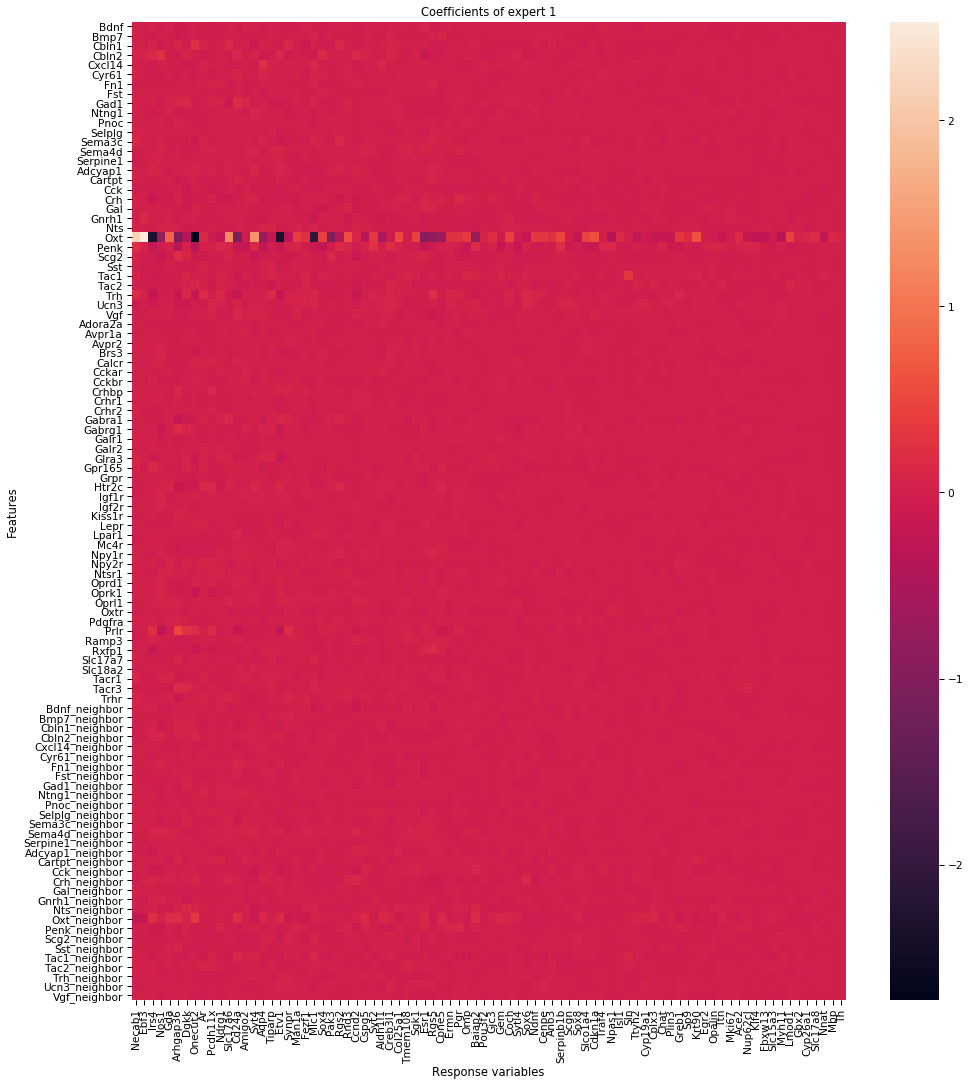

In [157]:
# model_experts is a dictionary index by 1st layer class and 2nd layer class
_weights = saved_model.model_experts[_expert[0]][_expert[1]].W[:,idx_dispersion]

df_plot = pd.DataFrame(_weights)
df_plot.index = total_regulators_neighbor_c
df_plot.columns = response_list_dispersion
plt.figure(figsize=(16,18))
sns.heatmap(df_plot, xticklabels=True, yticklabels=True)
plt.xticks(rotation=90)
plt.ylabel("Features")
plt.xlabel("Response variables")
plt.title(f"Coefficients of expert {_expert[1]}")
plt.show()
plt.close()

### Visualize experts' conditional covariance matrix (omega)

In [167]:
sns.set_context("paper", font_scale=1.2) 

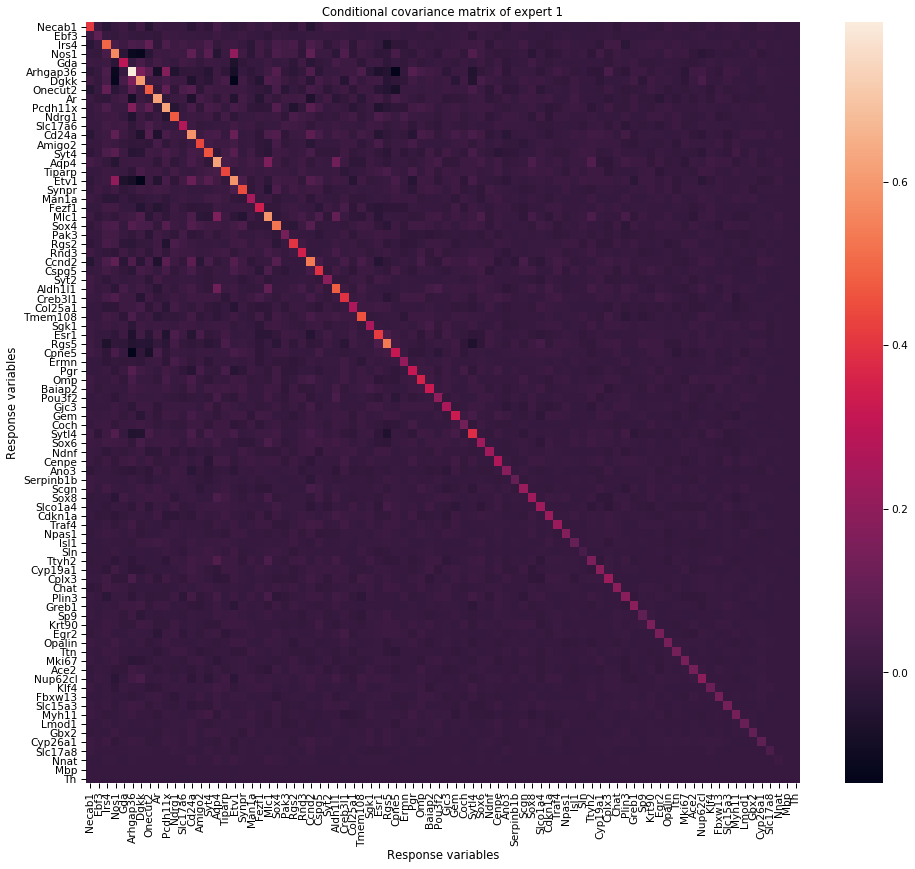

In [170]:
_omega = saved_model.model_experts[_expert[0]][_expert[1]].omega
_omega = _omega[:,idx_dispersion][idx_dispersion,:]
cutoff = 100

df_plot = pd.DataFrame(_omega[:,:cutoff][:cutoff,:])
df_plot.index = response_list_dispersion[:cutoff]
df_plot.columns = response_list_dispersion[:cutoff]
plt.figure(figsize=(16,14))
sns.heatmap(df_plot, xticklabels=True, yticklabels=True)
plt.ylabel("Response variables")
plt.xlabel("Response variables")
plt.title(f"Conditional covariance matrix of expert {_expert[1]}")
plt.show()
plt.close()

### Visualize classifier coefficients for different experts

In [177]:
coefs = saved_model.model_gates[0].coef_[:,:102]

In [178]:
df_plot = pd.DataFrame(coefs.T)
df_plot.index = total_regulators_neighbor_c

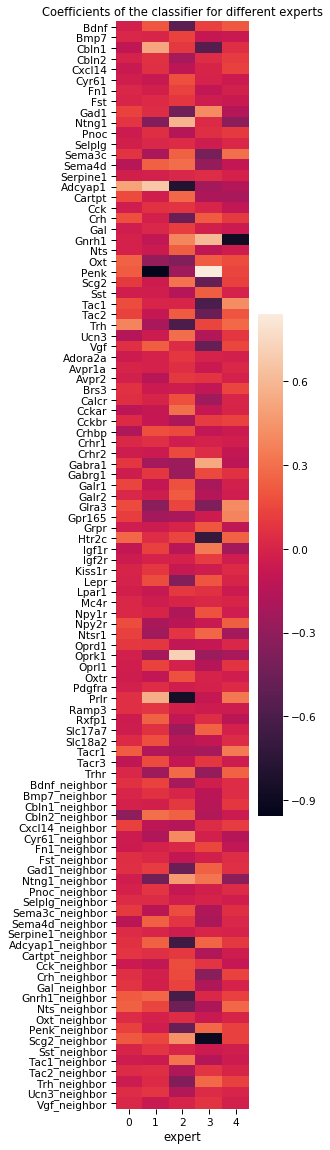

In [179]:
plt.figure(figsize=(3,20))
ax=sns.heatmap(df_plot)
plt.xlabel('expert')
plt.title("Coefficients of the classifier for different experts")
plt.show()
plt.close()

## Other configurations 

* Currently support 2 layers of classifiers
* Different experts and gates models can be used
    1. experts: MROTS, linear regresion, LASSO
    2. gates: logistic regression, decision trees 


### 2 layers of classifiers

In [173]:
# ------ set parameters ------
n_classes_0 = 2
n_classes_1 = 2
model_name_gates = 'logistic'
model_name_experts = 'mrots'
num_response = Y_train.shape[1]
tolerance = 3

if current_cell_type not in ['OD Mature 2', 'Astrocyte', 'Endothelial 1']:
    # soft weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = True
    partial_fit_expert = True

else:
    # hard weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = False
    partial_fit_expert = False

print(f"Parameters for MESSI: number of classes at level 1: {n_classes_0}, level 2: {n_classes_1}\n\
      model for gates: {model_name_gates}, model for experts: {model_name_experts}\n\
      if used soft weights: {soft_weights}")

# ------ initialize randomly ------
hier_labels = None

# ------ construct MESSI  ------
model = hme(n_classes_0, n_classes_1, model_name_gates, model_name_experts, num_response,
            init_labels_1=hier_labels, soft_weights=soft_weights,
            partial_fit_expert=partial_fit_expert, n_epochs=n_epochs, tolerance=tolerance)
# train
model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

Parameters for MESSI: number of classes at level 1: 2, level 2: 2
      model for gates: logistic, model for experts: mrots
      if used soft weights: True


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 1 ------
Best score: 1000000000.0
Current score: 242706.73887675768
level 1 gate error: 0.6919554685116982
level 2 gate error: [0.6797787815044465, 0.6799632783920484]
experts error: [61238.41082578807, 61141.9641033842, 60733.00537291597, 59591.30687714102]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 2 ------
Best score: 242706.73887675768
Current score: 237448.74244003044
level 1 gate error: 0.6913519198324749
level 2 gate error: [0.6645876684450428, 0.665905786557047]
experts error: [60981.275997608565, 58473.770024656646, 60285.89207206744, 57705.78250032292]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 3 ------
Best score: 237448.74244003044
Current score: 234193.00223275472
level 1 gate error: 0.6899331939508121
level 2 gate error: [0.6561523910164315, 0.6499521540162125]
experts error: [60191.95014044014, 55331.85886881473, 61508.11175960024, 57159.08542616062]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 4 ------
Best score: 234193.00223275472
Current score: 232238.94075850173
level 1 gate error: 0.6882555444673037
level 2 gate error: [0.6410128596375881, 0.6338462788014082]
experts error: [60079.625017574865, 53222.31115818295, 62067.09771198979, 56867.94375607121]
------ epoch 5 ------
Best score: 232238.94075850173
Current score: 230851.19608702013
level 1 gate error: 0.6862483624280161
level 2 gate error: [0.633151021279758, 0.613530846095366]
experts error: [59709.7708862503, 51745.61857948666, 62695.78834878786, 56698.08534226553]
5 epochs in total


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


#### make predictions

In [174]:
Y_hat_final = model.predict(X_test, X_test_clf_1, X_test_clf_2)
print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).sum(axis=1)).mean()}")

Mean absolute value : 39.10928559901218


### Use other models: e.g., use linear regression as the experts

In [182]:
# ------ set parameters ------
n_classes_0 = 1
n_classes_1 = 5
model_name_gates = 'logistic'
model_name_experts = 'linear'
num_response = Y_train.shape[1]
tolerance = 3

if current_cell_type not in ['OD Mature 2', 'Astrocyte', 'Endothelial 1']:
    # soft weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = True
    partial_fit_expert = True

else:
    # hard weights
    sub_condition = f"{condition}_{model_name_gates}_{model_name_experts}_soft"
    soft_weights = False
    partial_fit_expert = False

print(f"Parameters for MESSI: number of classes at level 1: {n_classes_0}, level 2: {n_classes_1}\n\
      model for gates: {model_name_gates}, model for experts: {model_name_experts}\n\
      if used soft weights: {soft_weights}")

# ------ initialize randomly ------
hier_labels = None

# ------ construct MESSI  ------
model = hme(n_classes_0, n_classes_1, model_name_gates, model_name_experts, num_response,
            init_labels_1=hier_labels, soft_weights=soft_weights,
            partial_fit_expert=partial_fit_expert, n_epochs=n_epochs, tolerance=tolerance)
# train
model.train(X_train, X_train_clf_1, X_train_clf_2, Y_train)

Parameters for MESSI: number of classes at level 1: 1, level 2: 5
      model for gates: logistic, model for experts: linear
      if used soft weights: True


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:149: UserWarning: Warining: partial fit for linear regression is same as complete fit when                 using all training samples to fit
  using all training samples to fit")
/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 1 ------
Best score: 1000000000.0
Current score: 239624.5459304724
level 1 gate error: 0
level 2 gate error: [1.581667593479782]
experts error: [47885.15772130259, 48063.069923081646, 49418.75019838199, 46937.535790953654, 47318.45062915906]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 2 ------
Best score: 239624.5459304724
Current score: 232630.74926486955
level 1 gate error: 0
level 2 gate error: [1.559092831224094]
experts error: [46907.1690185415, 46429.03030743891, 47819.399982098, 45323.09621117807, 46150.49465278186]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 3 ------
Best score: 232630.74926486955
Current score: 227239.9355196795
level 1 gate error: 0
level 2 gate error: [1.5386523526502682]
experts error: [46724.44017017566, 44342.308628114566, 47188.477024112806, 44085.62948237794, 44897.54156254589]


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


------ epoch 4 ------
Best score: 227239.9355196795
Current score: 223967.36401797656
level 1 gate error: 0
level 2 gate error: [1.5193205505324652]
experts error: [47274.24258472125, 42762.87540257523, 46819.97621335966, 42802.631860127396, 44306.11863664249]
------ epoch 5 ------
Best score: 223967.36401797656
Current score: 221895.57771446306
level 1 gate error: 0
level 2 gate error: [1.4960673466063759]
experts error: [48458.572153398796, 41675.15889862555, 46753.02299499281, 41259.01985251334, 43748.307747585946]
5 epochs in total


/home/dora/Documents/research/cell_interaction/messi/messi/hme.py:694: UserWarning: experts weights not sum to 1 for some samples!
  warnings.warn(f"experts weights not sum to 1 for some samples!")


#### make predictions

In [183]:
Y_hat_final = model.predict(X_test, X_test_clf_1, X_test_clf_2)
print(f"Mean absolute value : {(abs(Y_test - Y_hat_final).sum(axis=1)).mean()}")

Mean absolute value : 39.012664686646865
